# History Matching for L96
Author : Homer Durand

Date : 26-07-21

### Loading libs

In [1]:
current_dir <- getwd()
mogp_dir <- paste0(current_dir, "/mogp-emulator") #mogp_emulator lib

setwd(paste0(current_dir, '/dev_ExeterUQ_MOGP/'))

source("BuildEmulator/BuildEmulator.R")
source("HistoryMatching/HistoryMatching.R")
source("HistoryMatching/impLayoutplot.R")

setwd(current_dir)

L96_amip <- import("L96_amip")
np <- import("numpy")
smt <- import("smt")
sklearn <- import("sklearn")

packages <- c("FactoMineR", "factoextra", "corrplot", 'kernlab', 'pca3d', 'BBmisc', 'comprehenr', 'caret', "future.apply", 'tgp', 'ANN2', 'ramify')
# Install packages not yet installed
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {
  install.packages(packages[!installed_packages])
}

# Packages loading
invisible(lapply(packages, library, character.only = TRUE))

far library : Modelization for Functional AutoRegressive processes


version 0.6-4 (2014-12-07)


Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

This is loo version 2.4.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

Loading required package: future

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

corrplot 0.88 loaded

# History Matching

1. Space filling design of parameters space
2. Data simulation
3. Training of statistical emulator
4. Computation of implausibility
5. Refocussing
    * If stoping criterion is reached stop HM
    * Else, redefining parameters space and go to 1.

## Observations generation

As our model is a toy model we need to generate *observations* based on the ground truth parameters in order to use them to tune our model. In a realistic model (e.g. an ocean model), observations are metrics based on real observations of the state of the ocean threw time.

$\frac{d X_{k}}{d t}=\underbrace{-X_{k-1}\left(X_{k-2}-X_{k+1}\right)}_{\text {Advection}} \underbrace{-X_{k}}_{\text {Diffusion}}+\underbrace{F}_{\text {Forcing}} \underbrace{-h c \bar{Y}_{k}}_{\text {Coupling}}$

$\frac{1}{c} \frac{d Y_{j, k}}{d t}=\underbrace{-b Y_{j+1, k}\left(Y_{j+2, k}-Y_{j-1, k}\right)}_{\text {Advection }} \underbrace{-Y_{j, k}}_{\text {Diffusion }} \underbrace{+\frac{h}{J} X_{k}}_{\text {Coupling }}$

We consider the correct parameters to be h=1, F=10, c=10, b=10 and we will first generate our metrics based on those inputs using the 65 terms depicted here as in Schneider et al. 2017. 

$$
\boldsymbol{f}_k(Y)=\left(\begin{array}{c}
Y_{j,k} \\
Y_{j,k}Y_{j',k}
\end{array}\right), \forall j, j' \in J \text{ and } k \in K
$$

In [2]:
np$random$seed(as.integer(42))

X_init = 10*np$ones(as.integer(36))
X_init[19]=1.0001 #ATtention X_init[19] !!!

l96_two = L96_amip$L96TwoLevel(save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

We first iterate 10 iterations in order to access to the steady state of the L96 model

In [3]:
l96_two$iterate(10)

In [4]:
Newinit = l96_two$X
Newinit

[1]  4.42757870 -1.95495041  4.02579735  7.58204632  1.62852532  0.39357305
 [7] -0.27120997  0.50364081  1.39288414  7.19375682  4.24944906  4.31670564
[13] 10.65758988  3.57441467  0.28612741  1.59561931  5.81580349 -0.01928225
[19]  9.29077971  2.98459204  0.23466043 -1.10569887  5.99612019  5.39444981
[25]  1.73690034  0.13736713  1.49172092 -1.82474446 -0.34535066 10.71303763
[31]  1.52854734 -1.29510637  0.11986749  2.52317066  4.46499941 10.24747885

We can use *Newinit* to be sure to start from the attractor of the L96.

In [5]:
np$random$seed(as.integer(42))
n_iter <- 10 
dt <- 0.001
l96_two = L96_amip$L96TwoLevel(save_dt=dt, X_init=Newinit, integration_type='coupled') 

In [6]:
l96_two$iterate(n_iter)

We save the history of X in order to reinject it during the Y integration.

In [7]:
X_hist <- l96_two$history$X$values

We save the metrics generate with the ground truth parameters (observations).

In [8]:
system.time(observations <- l96_two$mean_stats(ax=as.integer(0)))

   user  system elapsed 
  1.638   0.001   1.643 

We now have our ground truth metrics and history of X wo we can tune our model.

### Generation of metrics for the first wave

We first sample the parameters space (input space) using a space filling design (latin hypercube sampling with maximin criterion) and then will generate our metrics for each of those points of the parameter space.

In [9]:
sampler <- import('skopt.sampler')
skSpace <- import('skopt.space')

In [10]:
n_samples <- 30

In [11]:
space <- skSpace$Space(list(c(-2, 2), c(0, 20), c(-20, 20))) ##only h,c,b
lhs <- sampler$Lhs()  #(lhs_type='classic', criterion='maximin', iterations=1000)
inputs_wave1 <- np$array(lhs$generate(space$dimensions, as.integer(n_samples), random_state=as.integer(42)))

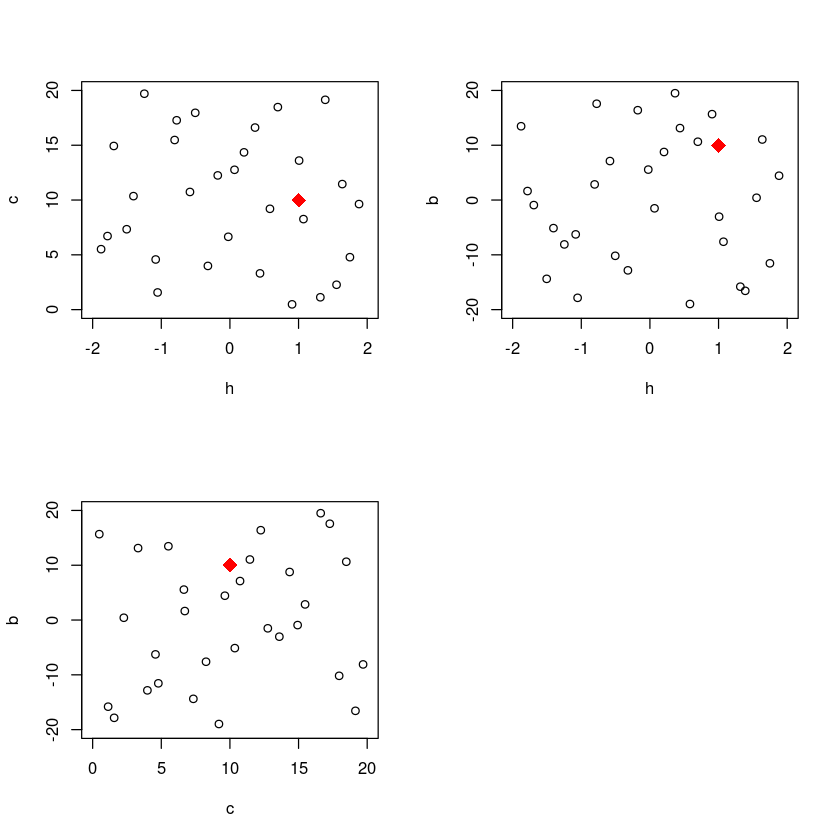

In [12]:
par(mfrow=c(2,2))
plot(inputs_wave1[,1], inputs_wave1[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,1], inputs_wave1[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,2], inputs_wave1[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

As a rule of thumb, we use 10 samples by paramaters. Here we have 3 parameters to tune (h, c, b), so we use 30 samples.

In [13]:
extract_metrics_AMIP <- function(p, n_iter, dt, X_hist) {
    initX <- as.matrix(X_hist[1,])
    l96_mip = L96_amip$L96TwoLevel(X_init=initX, save_dt=dt, dt=dt, noYhist=FALSE, h=p[[1]], F=10, c=p[[2]], b=p[[3]])
    l96_mip$iterate_AMIP(X_hist, n_iter)
    return(l96_mip$mean_stats(ax=as.integer(0)))
}

In [14]:
plan(multicore)
metrics_wave1 = future_sapply(1:nrow(inputs_wave1), function(r) extract_metrics_AMIP(inputs_wave1[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix
We create a data frame with correct format to train an emulator as it is describe in https://bayesexeter.github.io/ExeterUQ_MOGP/Testing_ExeterUQ_mogp.html

We select 65 metrics for a given k (here $k=0$) in order to fit the emulators in a reasonable amount of time. Here we select the metrics 

$$
\boldsymbol{f}_0(Y)=\left(\begin{array}{c}
Y_{j,0} \\
Y_{j,0}Y_{j',0}
\end{array}\right), \forall j, j' \in J
$$

#### Scaling and Unscaling functions

In [15]:
rangeScale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (range[2] - range[1])*(df[,i] - min)/(max - min) + range[1]
    }
    return(df)
}
                                        
rangeUnscale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (max - min)*(df[,i] - range[1])/(range[2] - range[1]) + min
    }
    return(df)
}

In [16]:
k <- 0 # Select k in K for tunning 
metrics_index_k <- (k*65+1):((k+1)*65)

In [17]:
# Arrange inputs (parameters) 
inputs_wave1 <- data.frame(inputs_wave1)
my_bounds <- data.frame(list(c(-2, 2), c(0, 20), c(-20, 20)))
inputs_wave1 <- rangeScale(inputs_wave1, my_bounds, range = c(-1, 1))
names(inputs_wave1) <- c('h', 'c', 'b')


metrics_k_wave1 <- data.frame(t(metrics_wave1)[, metrics_index_k])
N = nrow(inputs_wave1) 
noise <- rnorm(N, 0, 0)
tData <- data.frame(cbind(inputs_wave1, noise, metrics_k_wave1))
names(tData)[names(tData) == "noise"] <- "Noise"
         
head(tData)

,h,c,b,Noise,X1,X2,X3,X4,X5,X6,⋯,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.01201163,-0.3353458,0.2776930,0,-0.006420097,-0.006302724,-0.006309862,-0.006309524,-0.006308370,-0.006309555,⋯,8.040896e-05,8.060961e-05,7.764213e-05,0.0000799824,8.081122e-05,7.783269e-05,8.018136e-05,7.502619e-05,7.721373e-05,7.967611e-05
2,0.34905567,0.8478337,0.5320322,0,0.105538421,0.068697174,0.084799267,0.105912561,0.090199820,0.055292361,⋯,4.200927e-02,2.072397e-02,6.217308e-03,0.0177629503,3.367242e-02,1.393381e-02,1.070093e-02,2.560529e-02,1.471335e-02,4.267811e-02
3,0.50403953,0.3601328,-0.1518286,0,-0.006445521,0.237981995,-0.007404240,0.186781565,-0.014454777,0.215586632,⋯,3.415417e-02,2.000427e-02,2.256316e-02,0.0055672893,1.079500e-01,8.928603e-03,9.770488e-02,2.672015e-02,-6.281238e-03,1.157048e-01
4,-0.08859503,0.2247366,0.8196509,0,0.002876718,-0.045517209,0.003144312,-0.035722238,0.002147645,-0.039496303,⋯,9.518025e-04,6.397925e-04,7.712179e-04,0.0001814227,3.457189e-03,4.088819e-04,3.217118e-03,8.615864e-04,-1.074986e-04,3.813564e-03
5,-0.93853929,-0.4483700,0.6732339,0,-0.022457223,-0.094208743,-0.013564450,-0.057858226,-0.028031658,-0.088548652,⋯,8.612916e-02,2.743404e-03,3.030475e-02,0.0159979632,1.194932e-01,7.985882e-03,3.803280e-02,8.717307e-02,2.249705e-03,1.051677e-01
6,-0.40272438,0.5477225,0.1426025,0,-0.011566117,-0.221381152,-0.010322716,-0.182587973,-0.013466155,-0.196105155,⋯,2.254414e-02,1.924048e-02,1.833913e-02,0.0087921071,8.574896e-02,1.362513e-02,8.126697e-02,1.866998e-02,3.380719e-03,9.326263e-02


### Training emulator

In [18]:
cands <- names(tData)[1:3]
em_wave1 <- BuildNewEmulators(tData, HowManyEmulators = ncol(metrics_k_wave1), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.0324866889484487 using h"
[1] "Max reduction is 0.0080462388123647 using b"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ h + b + I(b * h), data = tData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.301661 -0.043256  0.003435  0.036234  0.284406 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.004889   0.018315  -0.267   0.7916    
h            0.159587   0.032470   4.915 4.21e-05 ***
b            0.081021   0.031912   2.539   0.0174 *  
I(b * h)     0.013509   0.062711   0.215   0.8311    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1003 on 26 degrees of freedom
Multiple R-squared:  0.5452,	Adjusted R-squared:  0.4928 
F-statistic: 10.39 on 3 and 26 DF,  p-value: 0.0001132

[1] "Max reduction is 0.0945718566703141 using h"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X2 ~ h, data = tData)

Residuals:
      Min        1Q

We can use Leave One Out to verify if our GPs fit our metrics correctly.

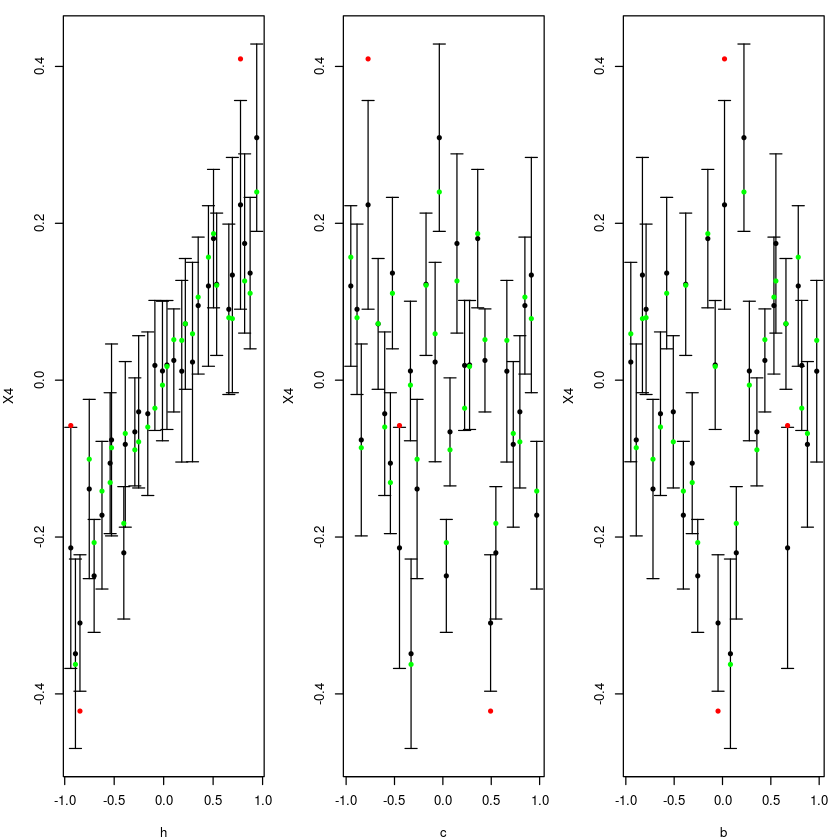

In [19]:
tLOOs <- LOO.plot(Emulators = em_wave1, which.emulator = 4, ParamNames = cands)

### Compute implausibility

We will compute implausibility as it is described in *Williamson & al. (2017)*.

$$
I_i(x_0) = \frac{|z_i - \mathbf{E}[f_i(x_0)]|}{|Var[z_i - \mathbf{E}[f_i(x_0)]]|} \\
I(x_0) = max_i(I_i(x_0))
$$

We consider that $Var[z_i - \mathbf{E}[f_i(x_0)]] = Var[e] +
Var[g] + Var[f(x_0)]$  like it is describe in *Williamson & al. (2017)*. 

With $Var[e]$ the observational
error variance, $Var[g]$ the model discrepancy variance
and $Var[f(x)]$ the variance of the emulator.

In [20]:
tDisc <- rep(0, ncol(metrics_k_wave1)) # model discrepancy variance Var[g] 
tObsErr <- rep(0, ncol(metrics_k_wave1)) # observational error variance Var[e]
tObs <-  as.vector(observations[metrics_index_k]) # Observations

We generate a large sampling of the parameter space (that we have scaled) and will compute implausibility for each point of this parameters space.

In [21]:
sample_size <- 100000
nparam <- length(names(em_wave1$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp) <- names(em_wave1$fitting.elements$Design)
system.time(Timps <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 68.936  21.597  15.635 

In [22]:
VarNames <- names(Xp)
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off
param.def = data.frame(h=c(1),c=c(10),b=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

    h c   b
1 0.5 0 0.5


In [23]:
NROY1 <- which(rowSums(Timps <= cutoff) >= em_wave1$mogp$n_emulators -valmax)
scoreNROY1 <- length(NROY1)/dim(Xp)[1]
scoreNROY1

[1] 0.32325

The first wave of tuning allowed us to reject approximately 70% of the parameters space.

### Layout of NROY space

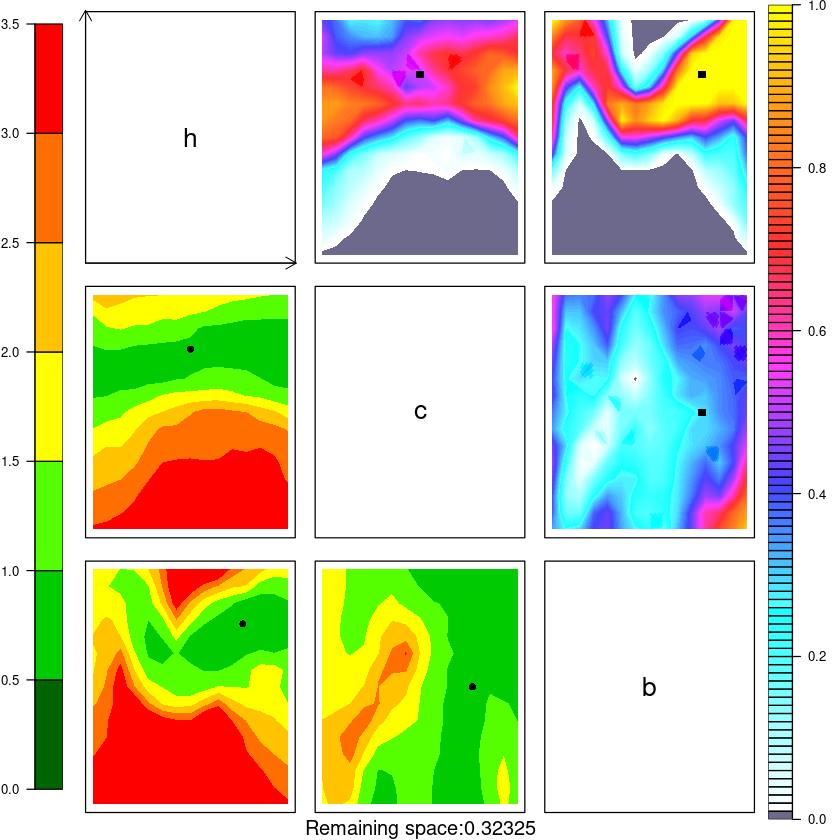

In [24]:
ImpData_wave1 = cbind(Xp, Timps)
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=em_wave1$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY1,sep=""), side=1)

## Second Wave

In [25]:
n <- ceiling(n_samples*1.3/scoreNROY1)

In [26]:
space <- skSpace$Space(list(c(-1, 1), c(-1, 1), c(-1, 1))) ## we use a scaled space
lhs <- sampler$Lhs()  #(lhs_type='classic', criterion='maximin', iterations=1000)
inputs_wave2_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [27]:
imp_em1_wave2 <- ImplausibilityMOGP(NewData=inputs_wave2_scaled_temp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_temp_wave2 <- which(rowSums(imp_em1_wave2 <= cutoff) >= em_wave1$mogp$n_emulators -valmax)

In [28]:
input_wave2_scaled <- inputs_wave2_scaled_temp[sample(NROY_temp_wave2, n_samples),]
input_wave2 <- rangeUnscale(input_wave2_scaled, my_bounds, range = c(-1, 1))

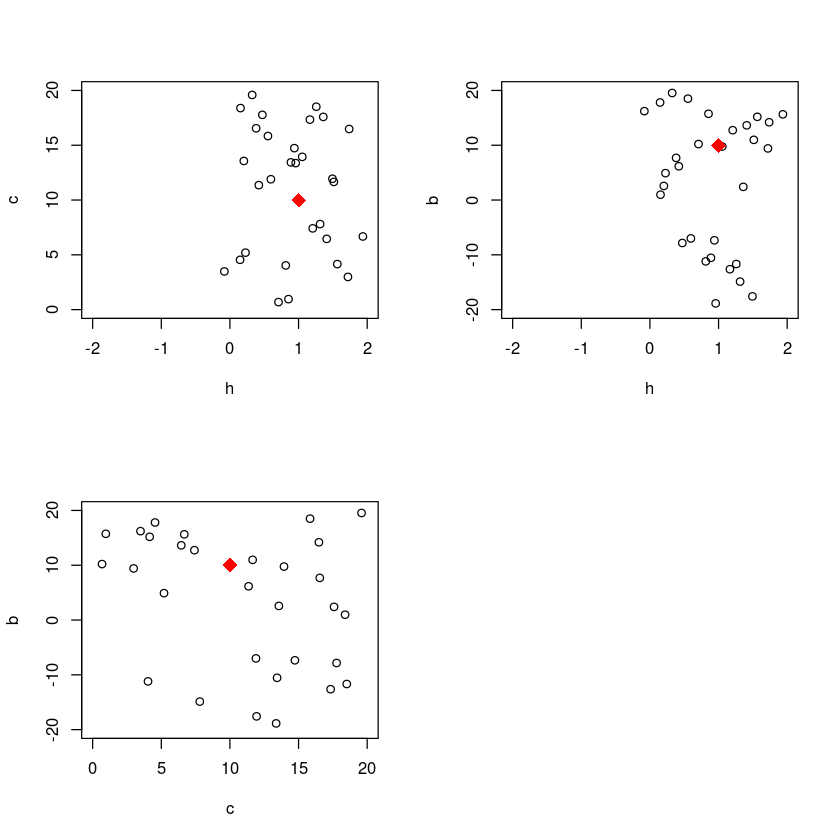

In [29]:
par(mfrow=c(2,2))
plot(input_wave2[,1], input_wave2[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave2[,1], input_wave2[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave2[,2], input_wave2[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [30]:
metrics_wave2 = future_sapply(1:nrow(input_wave2), function(r) extract_metrics_AMIP(input_wave2[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [31]:
input_wave2_scaled <- data.frame(input_wave2_scaled)
names(input_wave2_scaled) <- c('h', 'c', 'b')


metrics_k_wave2 <- data.frame(t(metrics_wave2)[, metrics_index_k])
N = nrow(metrics_k_wave2) 
noise <- rnorm(N, 0, 0)
tData_wave2 <- data.frame(cbind(input_wave2_scaled, noise, metrics_k_wave2))
names(tData_wave2)[names(tData_wave2) == "noise"] <- "Noise"
         
head(tData_wave2)

,h,c,b,Noise,X1,X2,X3,X4,X5,X6,⋯,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.68020025,0.7587067,0.1201003,0,0.29112436,0.28446270,0.31213874,0.29107906,0.28344010,0.25560862,⋯,0.232269522,0.183217440,0.144787139,0.1856461434,0.205439735,0.155632561,0.154081852,0.196904868,0.179533711,0.278834449
2,0.75702093,0.1654348,0.5492106,0,0.09157206,0.14349527,0.13115381,0.11564158,0.09662953,0.14479295,⋯,0.121512719,0.032016239,0.014253020,0.0247168950,0.099805981,0.025975665,-0.003044981,0.127203439,0.038401626,0.086464892
3,0.40687254,-0.5966457,-0.5596679,0,-0.03556975,0.10743538,-0.01220670,0.07366640,-0.01392719,0.09123871,⋯,0.017520324,0.001226138,0.013239613,0.0037391500,0.034582581,0.002552667,0.022729729,0.028055904,0.002684588,0.038549985
4,0.07407007,-0.5454909,0.8899468,0,0.02845276,0.03239768,0.03990326,0.03167529,0.03080419,0.03915296,⋯,0.002648988,0.001754668,0.002209366,0.0024346888,0.001702447,0.001956978,0.001678801,0.003192820,0.002838591,0.003452166
5,0.10133393,0.3565289,0.1286555,0,0.04796279,0.05145438,0.05220190,0.05238237,0.05349005,0.05376457,⋯,0.006160198,0.006166283,0.007211748,0.0067863767,0.006181959,0.007213883,0.006777280,0.008630125,0.007978206,0.007677637
6,0.23630436,0.7772796,-0.3919102,0,-0.01375215,0.10026724,-0.01625288,0.07844360,-0.02437055,0.09176273,⋯,0.005737277,0.001496423,0.004237555,-0.0007044235,0.020420500,0.001084486,0.017424595,0.005589249,-0.002253022,0.020858350


### Training emulator

In [32]:
em_wave2 <- BuildNewEmulators(tData_wave2, HowManyEmulators = ncol(metrics_wave2), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.00834265792697923 using b"
[1] "Max reduction is 0.00323686634426941 using h"
[1] "Max reduction is 0.00662904143727792 using b"
[1] "Max reduction is 0.00475837123875397 using b"
[1] "Max reduction is 0.00870192952526664 using b"
[1] "Max reduction is 0.00153755214425141 using h"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ b + I(b^2) + I(b^3) + I(b^4) + h + I(h^2) + 
    I(h * b), data = tData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.076826 -0.013613 -0.003309  0.007435  0.094626 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.01207    0.02517   0.480 0.636264    
b            0.23438    0.04627   5.065  4.5e-05 ***
I(b^2)      -0.50910    0.11254  -4.524 0.000168 ***
I(b^3)      -0.14080    0.04893  -2.878 0.008740 ** 
I(b^4)       0.44569    0.11506   3.873 0.000821 ***
h            0.38596    0.11281   3.421 0.002443 ** 
I(h^2)      -0.18999    0.11106  -1.711 0.101213    
I(

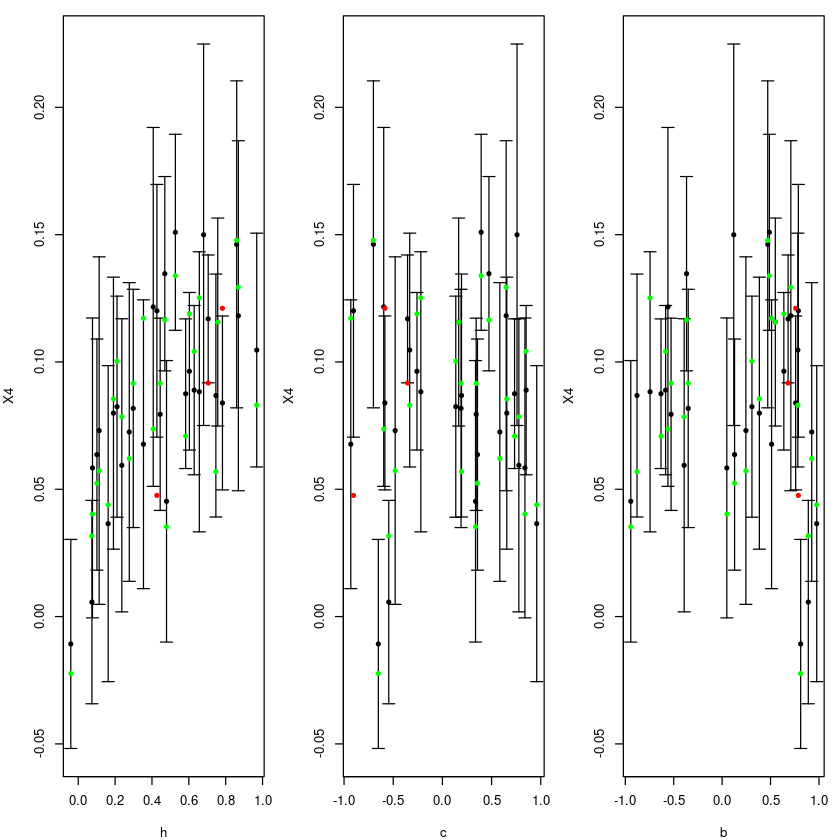

In [33]:
tLOOs <- LOO.plot(Emulators = em_wave2, which.emulator = 4, ParamNames = cands)

### Compute implausibility

In [34]:
sample_size <- 100000
nparam <- length(names(em_wave2$fitting.elements$Design))
Xp_wave2 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave2) <- names(em_wave2$fitting.elements$Design)
system.time(Timps_wave2 <- ImplausibilityMOGP(NewData=Xp_wave2, Emulator=em_wave2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 20.414   5.193   4.920 

Warning : Here we set valmax to 3 to generate a more steady NROY space

In [35]:
valmax = 1 #Set to 2 in order to have a "more steady" NROY space
cutoff <- 3 #the implausibility cut off

In [36]:
NROY2 <- which(rowSums(Timps_wave2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)
scoreNROY2 <- length(NROY2)/dim(Xp_wave2)[1]

### Layout of NROY space

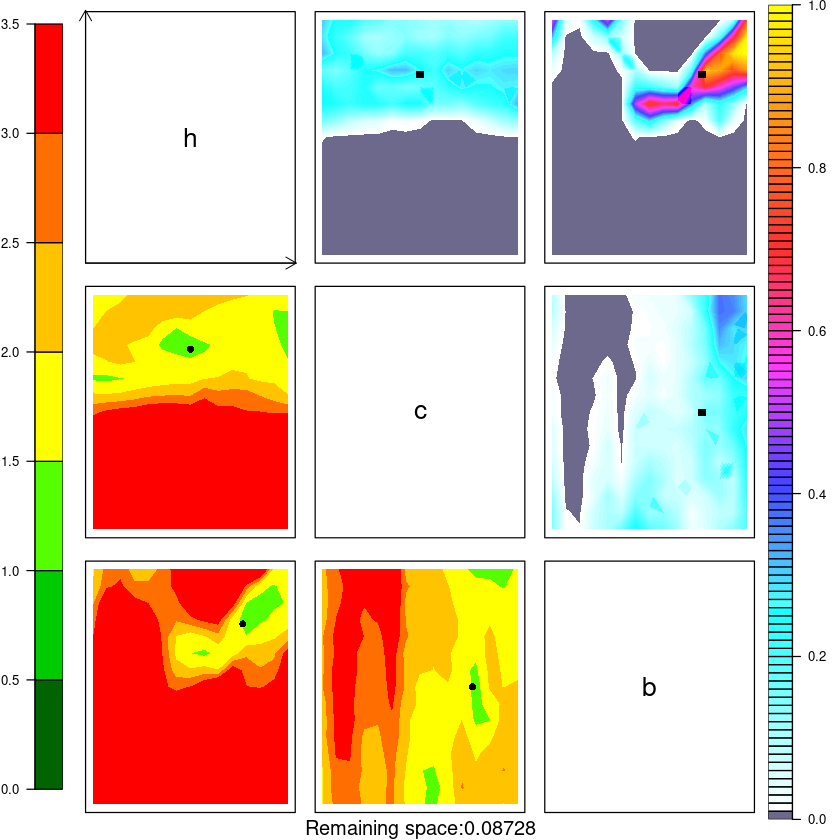

In [37]:
ImpData_wave2 = cbind(Xp_wave2, Timps_wave2)
ImpListM2 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave2, nEms=em_wave2$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM2,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY2,sep=""), side=1)

## Third Wave

In [38]:
n <- ceiling(n_samples*1.6/scoreNROY2)

In [39]:
inputs_wave3_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [40]:
imp_em1 <- ImplausibilityMOGP(NewData=inputs_wave3_scaled_temp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em1 <- which(rowSums(imp_em1 <= cutoff) >= em_wave1$mogp$n_emulators -valmax)

imp_em2 <- ImplausibilityMOGP(NewData=inputs_wave3_scaled_temp, Emulator=em_wave2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em2 <- which(rowSums(imp_em2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)

In [41]:
inter_12 <- intersect(NROY_em1, NROY_em2)
length(inter_12)

[1] 43

In [42]:
NROY_temp_wave3 <- sample(intersect(NROY_em1, NROY_em2), n_samples)

In [43]:
input_wave3_scaled <- inputs_wave3_scaled_temp[sample(NROY_temp_wave3, n_samples),]
input_wave3 <- rangeUnscale(input_wave3_scaled, my_bounds, range = c(-1, 1))

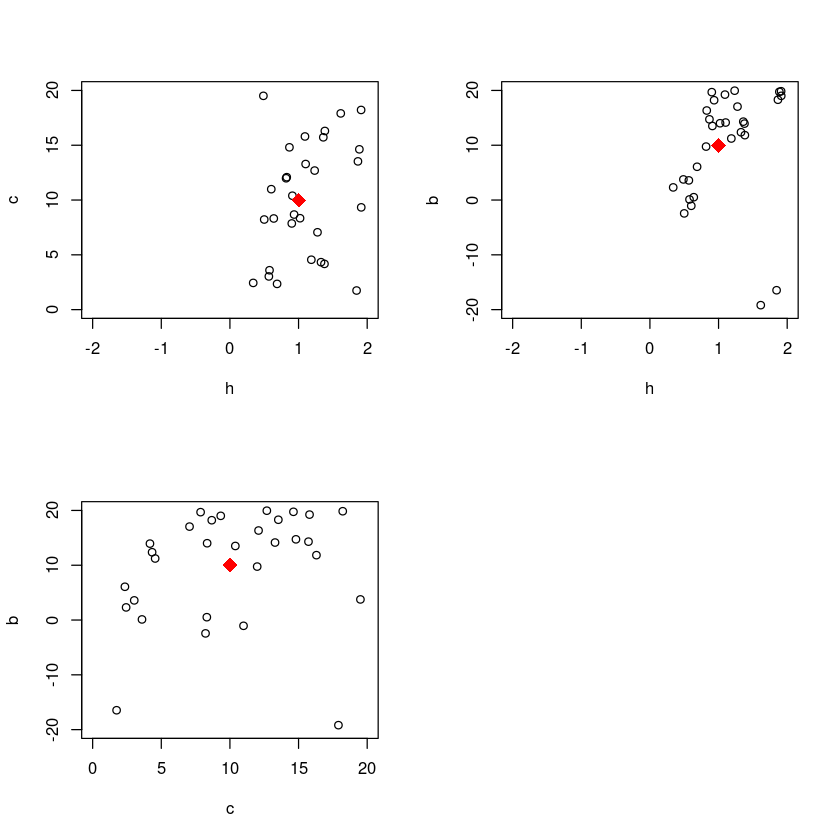

In [44]:
par(mfrow=c(2,2))
plot(input_wave3[,1], input_wave3[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave3[,1], input_wave3[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave3[,2], input_wave3[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [45]:
metrics_wave3 = future_sapply(1:nrow(input_wave3), function(r) extract_metrics_AMIP(input_wave3[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [46]:
input_wave3_scaled <- data.frame(input_wave3_scaled)
names(input_wave3_scaled) <- c('h', 'c', 'b')


metrics_k_wave3 <- data.frame(t(metrics_wave3)[, metrics_index_k])
N = nrow(metrics_k_wave3) 
noise <- rnorm(N, 0, 0)
tData_wave3 <- data.frame(cbind(input_wave3_scaled, noise, metrics_k_wave3))
names(tData_wave3)[names(tData_wave3) == "noise"] <- "Noise"
         
head(tData_wave3)

,h,c,b,Noise,X1,X2,X3,X4,X5,X6,⋯,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.4335158,0.48099096,0.7363509,0,0.09036992,0.06069523,0.08443499,0.08880784,0.07285993,0.07083059,⋯,0.04258415,0.017117700,0.002086924,0.0139203629,0.03813748,0.010689627,0.0064463906,0.03513797,0.01182824,0.04273570
2,0.4550703,0.03942389,0.6757804,0,0.06974464,0.08704162,0.07632987,0.08165849,0.10304563,0.08633024,⋯,0.04297436,0.015390012,0.002837992,0.0110654071,0.04663379,0.020888987,0.0014587700,0.04856879,0.01340827,0.04165079
3,0.9227896,-0.82553353,-0.8230776,0,0.08466303,0.07630198,0.04074534,0.12103289,0.10751258,0.09171788,⋯,0.07281696,-0.001607276,0.009391699,-0.0006733187,0.08441429,-0.008525222,0.0338612140,0.06190399,-0.01415861,0.08496663
4,0.6172428,0.26894467,0.9977066,0,0.05241382,0.07513234,0.05979088,0.08211781,0.07962184,0.07387690,⋯,0.06758385,0.017554978,0.002296934,0.0160301984,0.06082045,0.015768774,0.0006535878,0.06471785,0.01383417,0.05494077
5,0.4139060,0.20857480,0.8168151,0,0.06852024,0.06646516,0.08388401,0.08280325,0.05333434,0.07687877,⋯,0.03528761,0.012724226,0.003488363,0.0143266727,0.03497353,0.008677762,0.0031881856,0.03190783,0.01188156,0.03699706
6,0.3012676,0.09907643,-0.0526847,0,0.16508660,0.15521236,0.15643382,0.15874667,0.15138708,0.16039750,⋯,0.04785279,0.053106044,0.041327742,0.0500651277,0.05983262,0.045657484,0.0564746340,0.03643022,0.04340062,0.05617101


### Training emulator

In [47]:
em_wave3 <- BuildNewEmulators(tData_wave3, HowManyEmulators = ncol(metrics_wave3), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.00493318136697817 using h"
[1] "Max reduction is 0.00331945711074788 using b"
[1] "Max reduction is 0.00236583673412933 using c"
[1] "Max reduction is 0.000740996748427789 using b"
[1] "Max reduction is 0.00410947814150418 using b"
[1] "Max reduction is 0.0005789464927284 using Three Way Interactions with b"
[1] "Max reduction is 0.00322784740033127 using b"
[1] "Max reduction is 0.00033689182505907 using b"
[1] "Max reduction is 0.000251047097419112 using b"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = X1 ~ h + b + I(b^2) + I(b^3) + I(b^4) + I(b^5) + 
    I(b^6) + c + I(b * h) + I(c * h) + I(c * b) + I(b * b * h) + 
    I(b * c * h) + I(b * c * b), data = tData)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0161102 -0.0085767 -0.0000845  0.0079442  0.0229798 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.000352   0.037921  -0.009  0.99272    
h            

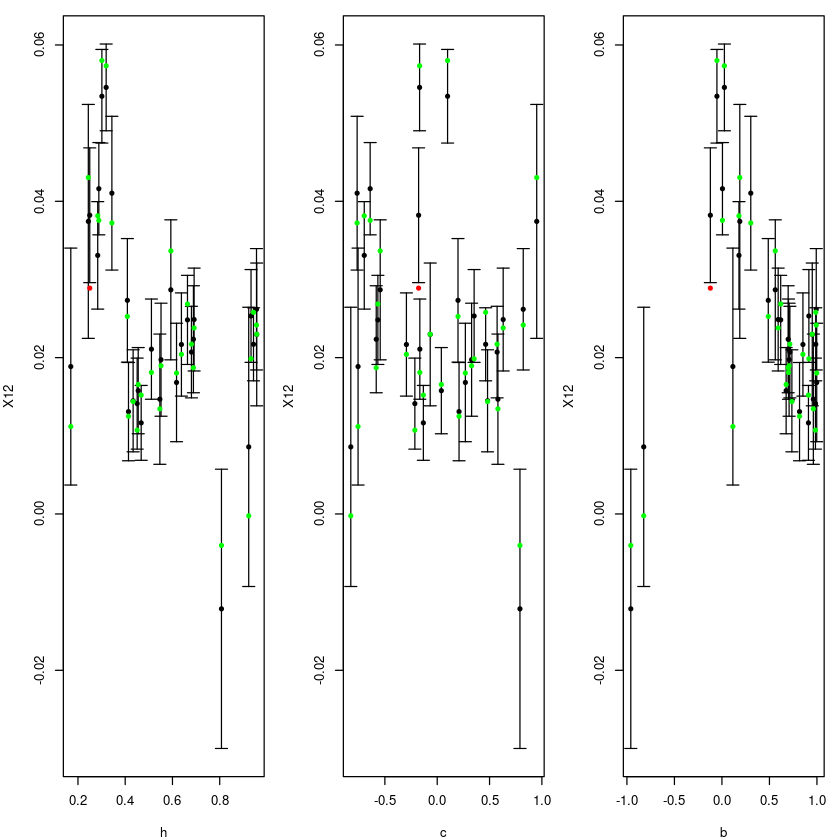

In [48]:
tLOOs <- LOO.plot(Emulators = em_wave3, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [49]:
sample_size <- 100000
nparam <- length(names(em_wave3$fitting.elements$Design))
Xp_wave3 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave3) <- names(em_wave3$fitting.elements$Design)
system.time(Timps_wave3 <- ImplausibilityMOGP(NewData=Xp_wave3, Emulator=em_wave3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 21.819   4.294   4.672 

In [53]:
valmax = 1 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [54]:
NROY3 <- which(rowSums(Timps_wave3 <= cutoff) >= em_wave3$mogp$n_emulators -valmax)
scoreNROY3 <- length(NROY3)/dim(Xp_wave3)[1]

### Layout of NROY space

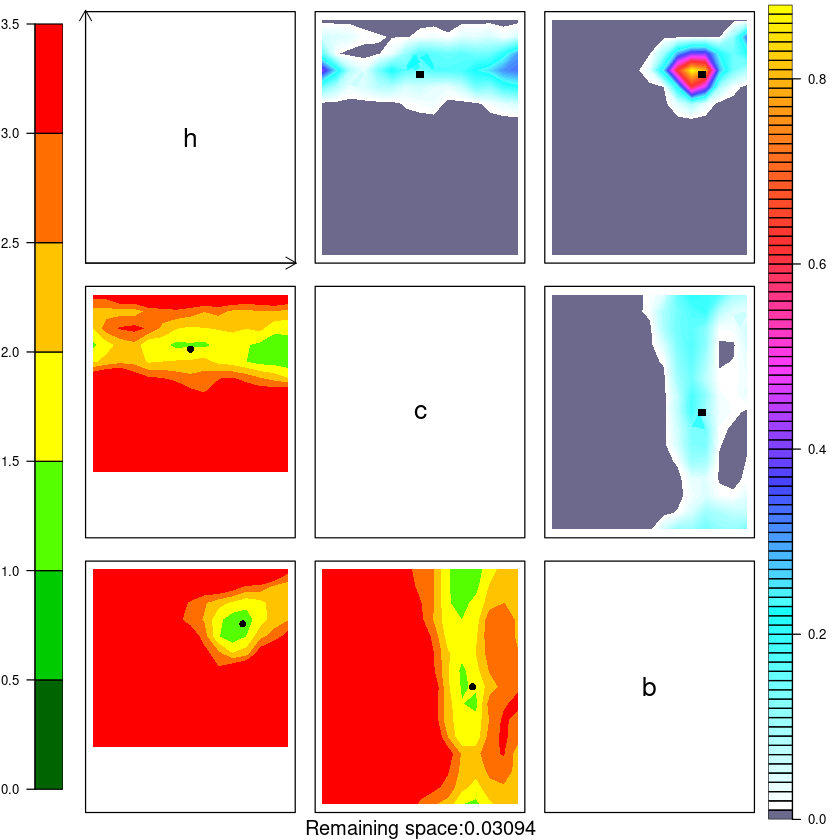

In [55]:
ImpData_wave3 = cbind(Xp_wave3, Timps_wave3)
ImpListM3 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave3, nEms=em_wave3$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM3,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY3,sep=""), side=1)

## Fourth Wave

In [56]:
n <- ceiling(n_samples*4/scoreNROY3)

In [57]:
inputs_wave4_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [58]:
imp_em1 <- ImplausibilityMOGP(NewData=inputs_wave4_scaled_temp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em1 <- which(rowSums(imp_em1 <= cutoff) >= em_wave1$mogp$n_emulators -valmax)

imp_em2 <- ImplausibilityMOGP(NewData=inputs_wave4_scaled_temp, Emulator=em_wave2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em2 <- which(rowSums(imp_em2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)

imp_em3 <- ImplausibilityMOGP(NewData=inputs_wave4_scaled_temp, Emulator=em_wave3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em3 <- which(rowSums(imp_em3 <= cutoff) >= em_wave3$mogp$n_emulators -valmax)

In [59]:
inter12 <- intersect(NROY_em1, NROY_em2)
NROY_em123 <- intersect(inter12, NROY_em3)

In [60]:
length(NROY_em123)

[1] 58

In [61]:
NROY_temp_wave4 <- sample(NROY_em123, n_samples)

In [62]:
input_wave4_scaled <- inputs_wave4_scaled_temp[sample(NROY_temp_wave4, n_samples),]
input_wave4 <- rangeUnscale(input_wave4_scaled, my_bounds, range = c(-1, 1))

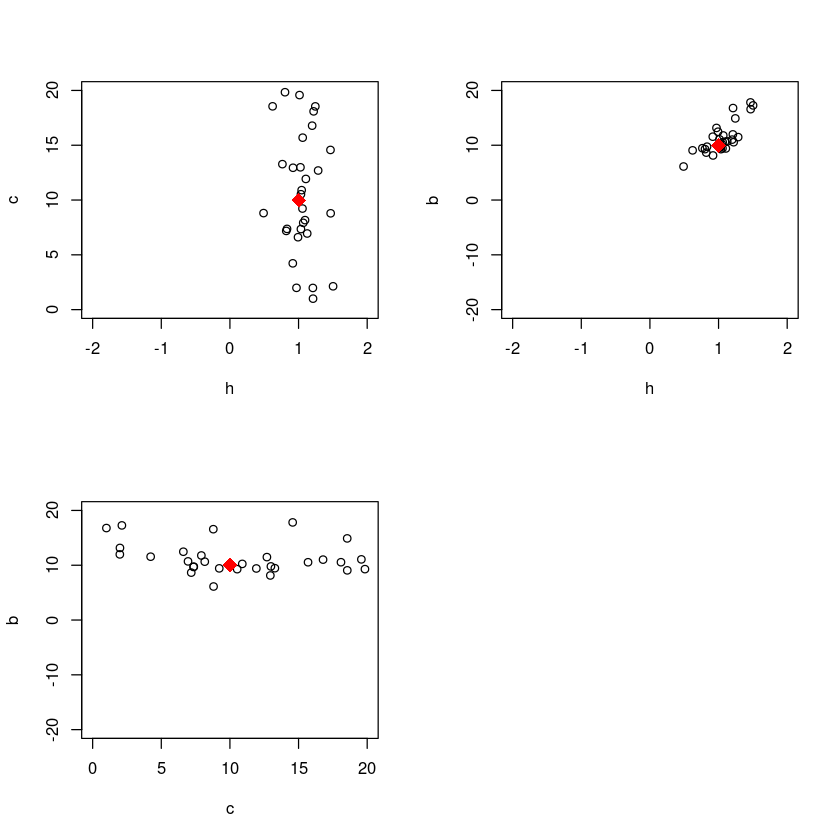

In [63]:
par(mfrow=c(2,2))
plot(input_wave4[,1], input_wave4[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,1], input_wave4[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,2], input_wave4[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [64]:
metrics_wave4 = future_sapply(1:nrow(input_wave4), function(r) extract_metrics_AMIP(input_wave4[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [65]:
input_wave4_scaled <- data.frame(input_wave4_scaled)
names(input_wave4_scaled) <- c('h', 'c', 'b')


metrics_k_wave4 <- data.frame(t(metrics_wave4)[, metrics_index_k])
N = nrow(metrics_k_wave4) 
noise <- rnorm(N, 0, 0)
tData_wave4 <- data.frame(cbind(input_wave4_scaled, noise, metrics_k_wave4))
names(tData_wave4)[names(tData_wave4) == "noise"] <- "Noise"
         
head(tData_wave4)

,h,c,b,Noise,X1,X2,X3,X4,X5,X6,⋯,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.6428025,0.26943590,0.5742040,0,0.10801954,0.12060185,0.08406143,0.11314543,0.11408898,0.10285006,⋯,0.09793536,0.03144641,-0.0001215834,0.022793136,0.08701478,0.02679364,0.008773059,0.06843820,0.01812094,0.09140633
2,0.4960481,-0.33927047,0.6233235,0,0.08399264,0.09093085,0.08135755,0.09928556,0.09509831,0.06736279,⋯,0.05255222,0.01835094,-0.0004751822,0.009614645,0.04697592,0.01759291,0.002070841,0.04197602,0.01279694,0.04429588
3,0.5069952,0.95763191,0.5534706,0,0.11405665,0.09562067,0.12195410,0.09776977,0.11729028,0.11164360,⋯,0.04989562,0.01770260,0.0091540721,0.017849979,0.05631665,0.02581618,0.004704681,0.07078707,0.02377571,0.05253850
4,0.5226636,0.09014729,0.5122973,0,0.11032870,0.10263765,0.10260257,0.10264918,0.14253598,0.07461718,⋯,0.05527029,0.03007873,0.0050393093,0.012431624,0.07002702,0.02647697,0.005804734,0.06417992,0.02094366,0.06258217
5,0.4597412,0.29448593,0.4066977,0,0.12479636,0.12225799,0.08951345,0.14651205,0.09121890,0.09857169,⋯,0.07601175,0.03720801,0.0121991376,0.032489044,0.06012438,0.02736608,0.016904149,0.05225471,0.02626856,0.07349589
6,0.6097872,0.80908268,0.5274830,0,0.08354644,0.10007706,0.12669783,0.11236564,0.10831744,0.11997897,⋯,0.08052693,0.02639258,0.0077876651,0.020451162,0.08025602,0.02978872,0.005075685,0.08935504,0.02701642,0.07463620


### Training emulator

In [66]:
em_wave4 <- BuildNewEmulators(tData_wave4, HowManyEmulators = ncol(metrics_wave4), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.00478838031452439 using b"
[1] "Max reduction is 0.000667152474510359 using c"
[1] "Max reduction is 0.000129476349338596 using c"
[1] "Max reduction is 0.000592017885476906 using Three Way Interactions with c"
[1] "Max reduction is 0.00139654367833002 using h"
[1] "Max reduction is 0.000143716182634493 using h"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ b + c + I(c^2) + h + I(h^2) + I(c * b) + I(h * 
    b) + I(h * c) + I(c * c * b) + I(c * h * b) + I(c * h * c), 
    data = tData)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0234507 -0.0052969  0.0007649  0.0066004  0.0187215 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)   0.091220   0.048158   1.894   0.0744 .
b            -0.283730   0.251259  -1.129   0.2736  
c            -0.296947   0.173952  -1.707   0.1050  
I(c^2)       -0.004286   0.068449  -0.063   0.9508  
h             0.451588   0.254504   1.774   0.0929 .
I(h^2)  

We can use Leave One Out to verify if our GPs fit our metrics correctly.

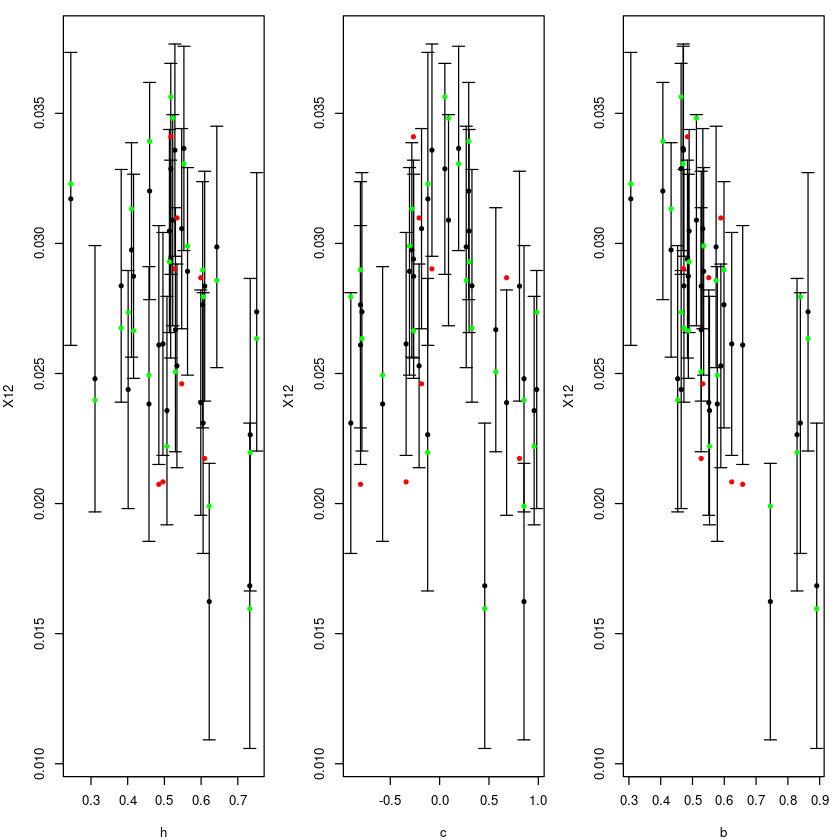

In [67]:
tLOOs <- LOO.plot(Emulators = em_wave4, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [68]:
sample_size <- 100000
nparam <- length(names(em_wave4$fitting.elements$Design))
Xp_wave4 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave4) <- names(em_wave4$fitting.elements$Design)
system.time(Timps_wave4 <- ImplausibilityMOGP(NewData=Xp_wave4, Emulator=em_wave4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 20.712   4.488   4.585 

In [69]:
valmax = 2 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [70]:
NROY4 <- which(rowSums(Timps_wave4 <= cutoff) >= em_wave4$mogp$n_emulators -valmax)
scoreNROY4 <- length(NROY4)/dim(Xp_wave4)[1]

### Layout of NROY space

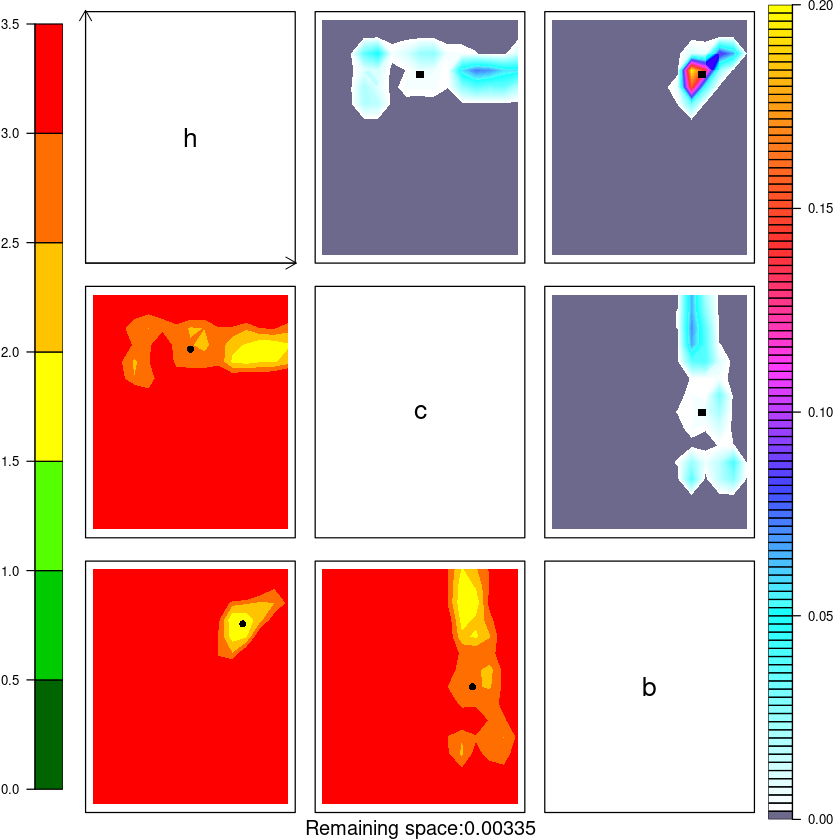

In [71]:
ImpData_wave4 = cbind(Xp_wave4, Timps_wave4)
ImpListM4 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave4, nEms=em_wave4$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM4,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY4,sep=""), side=1)

## Fifth Wave

In [72]:
n <- ceiling(n_samples*4/scoreNROY4)

In [ ]:
inputs_wave5_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [ ]:
imp_em1 <- ImplausibilityMOGP(NewData=inputs_wave4_scaled_temp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em1 <- which(rowSums(imp_em1 <= cutoff) >= em_wave1$mogp$n_emulators -valmax)

imp_em2 <- ImplausibilityMOGP(NewData=inputs_wave4_scaled_temp, Emulator=em_wave2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em2 <- which(rowSums(imp_em2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)

imp_em3 <- ImplausibilityMOGP(NewData=inputs_wave4_scaled_temp, Emulator=em_wave3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em3 <- which(rowSums(imp_em3 <= cutoff) >= em_wave3$mogp$n_emulators -valmax)

imp_em4 <- ImplausibilityMOGP(NewData=inputs_wave4_scaled_temp, Emulator=em_wave4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em4 <- which(rowSums(imp_em4 <= cutoff) >= em_wave4$mogp$n_emulators -valmax)

In [ ]:
inter12 <- intersect(NROY_em1, NROY_em2)
inter123 <- intersect(inter12, NROY_em3)
NROY_em1234 <- intersect(inter123, NROY_em4)

In [ ]:
length(NROY_em1234)

In [ ]:
NROY_temp_wave5 <- sample(NROY_em1234, n_samples)

In [ ]:
input_wave5_scaled <- inputs_wave5_scaled_temp[sample(NROY_temp_wave5, n_samples),]
input_wave5 <- rangeUnscale(input_wave5_scaled, my_bounds, range = c(-1, 1))

In [ ]:
par(mfrow=c(2,2))
plot(input_wave5[,1], input_wave5[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave5[,1], input_wave5[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave5[,2], input_wave5[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [ ]:
metrics_wave5 = future_sapply(1:nrow(input_wave5), function(r) extract_metrics_AMIP(input_wave5[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [ ]:
input_wave5_scaled <- data.frame(input_wave5_scaled)
names(input_wave5_scaled) <- c('h', 'c', 'b')


metrics_k_wave5 <- data.frame(t(metrics_wave5)[, metrics_index_k])
N = nrow(metrics_k_wave5) 
noise <- rnorm(N, 0, 0)
tData_wave5 <- data.frame(cbind(input_wave5_scaled, noise, metrics_k_wave4))
names(tData_wave5)[names(tData_wave5) == "noise"] <- "Noise"
         
head(tData_wave5)

### Training emulator

In [ ]:
em_wave5 <- BuildNewEmulators(tData_wave4, HowManyEmulators = ncol(metrics_wave4), meanFun = "fitted", additionalVariables = cands) # 

We can use Leave One Out to verify if our GPs fit our metrics correctly.

In [ ]:
tLOOs <- LOO.plot(Emulators = em_wave5, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [ ]:
sample_size <- 100000
nparam <- length(names(em_wave5$fitting.elements$Design))
Xp_wave5 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave5) <- names(em_wave5$fitting.elements$Design)
system.time(Timps_wave5 <- ImplausibilityMOGP(NewData=Xp_wave5, Emulator=em_wave5, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

In [ ]:
valmax = 2 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [ ]:
NROY5 <- which(rowSums(Timps_wave5 <= cutoff) >= em_wave5$mogp$n_emulators -valmax)
scoreNROY5 <- length(NROY5)/dim(Xp_wave5)[1]

### Layout of NROY space

In [ ]:
ImpData_wave5 = cbind(Xp_wave5, Timps_wave5)
ImpListM5 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave5, nEms=em_wave5$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM5,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY5,sep=""), side=1)